<a href="https://colab.research.google.com/github/Aryan-401/GoogleColabProjects/blob/main/TTS_FineTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers datasets soundfile speechbrain accelerate

In [50]:
from huggingface_hub import notebook_login

notebook_login()

In [51]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "nl", split="train")
len(dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for facebook/voxpopuli contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/voxpopuli
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


20968

In [52]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [53]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [54]:
tokenizer = processor.tokenizer

In [55]:
dataset[0]

{'audio_id': '20100210-0900-PLENARY-3-nl_20100210-09:06:43_4',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/02ec6a19d5b97c03e1379250378454dbf3fa2972943504a91c7da5045aa26a89/train_part_0/20100210-0900-PLENARY-3-nl_20100210-09:06:43_4.wav',
  'array': array([ 4.27246094e-04,  1.31225586e-03,  1.03759766e-03, ...,
         -9.15527344e-05,  7.62939453e-04, -2.44140625e-04]),
  'sampling_rate': 16000},
 'raw_text': 'Dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'normalized_text': 'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'gender': 'female',
 'speaker_id': '1122',
 'is_gold_transcript': True,
 'accent': 'None'}

In [56]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

In [57]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

In [58]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

In [59]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

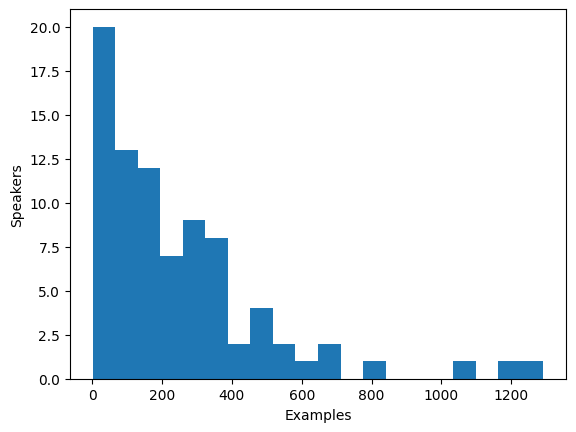

In [60]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [61]:
def select_speaker(speaker_id):
    return 300 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/20968 [00:00<?, ? examples/s]

In [62]:
len(set(dataset["speaker_id"]))

12

In [63]:
len(dataset)

4128

In [64]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [65]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [66]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [67]:
processed_example["speaker_embeddings"].shape

(512,)

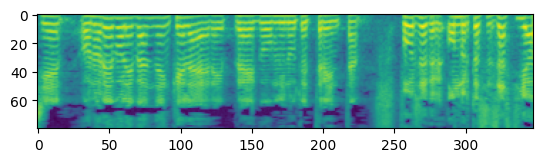

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [69]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/4128 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (750 > 600). Running this sequence through the model will result in indexing errors


In [70]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/4128 [00:00<?, ? examples/s]

3433

In [71]:
dataset = dataset.train_test_split(test_size=0.1)

In [72]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [73]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [74]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [75]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [77]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=50,
    max_steps=100,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=100,
    eval_steps=100,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [78]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

In [79]:
kwargs = {
     "dataset_tags": "facebook/voxpopuli",
    "finetuned_from": "speechbrain/spkrec-xvect-voxceleb",
    "tasks": "text-to-speech",
}

In [80]:
trainer.train()
trainer.push_to_hub(**kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.676100,0.592839


events.out.tfevents.1703661700.0e16df1220e0.771.2:   0%|          | 0.00/7.11k [00:00<?, ?B/s]

'https://huggingface.co/Aryan-401/speecht5_finetuned_voxpopuli_nl/tree/main/'